[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/sk-classroom/asc-recurrent-neural-nets/blob/main/assignments/assignment_02.ipynb)

We will be creating a character-level LSTM trained on The Foundation by Isaac Asimov.  

This character-level LSTM will read the book at character levels and be trained to predict the next character. By repeating the next character predictions, the LSTM will generate text in style similar to Isaac Asimov (if you train well).  

# Data 

We will use the text in [archive.org](https://archive.org/stream/AsimovTheFoundation/Asimov_the_foundation_djvu.txt). The text is preprocessed and saved in "data/the-foundation.txt".  


In [5]:
import numpy as np
import re

root = "../"

# %% Extract the main content of the book
## Reading and processing text
with open(f"{root}/data/the-foundation.txt", "r", encoding="utf8") as fp:
    full_text_data = fp.read()

# Remove linebreaks from the text
full_text_data = full_text_data.replace("\n", " ")
full_text_data = full_text_data.replace("\r", " ")
full_text_data = full_text_data.replace("\\'", "'")

# Replace multiple spaces with a single space
full_text_data = re.sub(r"\s+", " ", full_text_data)

We will extract the content of the book, and convert the text into a sequence of integers. 


In [7]:
start_indx = full_text_data.find("THE PSYCHOHISTORIANS")
end_indx = len(full_text_data)

full_text_data = full_text_data[start_indx:end_indx]
char_set = set(full_text_data)
print("Total Length:", len(full_text_data))
print("Unique Characters:", len(char_set))

# Tokenize the text into integers reresenting characters
## Creating a lookup table
chars = sorted(char_set)
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = np.array(chars)

Total Length: 1215346
Unique Characters: 83


Since the book is too long, we will only use the first 100000 characters for the training. 


In [8]:
text_data = full_text_data[:100000]

For convenience, let's convert the text into an integer sequence:


In [9]:
text_as_int = np.array(list(map(lambda x: char_to_int[x], text_data)), dtype=np.int32)

In [10]:
# The text_as_int contains the encoded values for all the characters in the text. Let's take a look at how part of our text is encoded:
print("Text:", text_data[:20], "\nEncoded:", text_as_int[:20])

Text: THE PSYCHOHISTORIANS 
Encoded: [45 33 30  0 41 44 50 28 33 40 33 34 44 45 40 43 34 26 39 44]


## Create the dataset for training the Long-term short memory 

In this exercise, we will feed a fixed number of characters into the LSTM to predict the next character. While it is possible to feed all previous characters, it is not practical due to the memory and computation time. 

More concretely, for example, given text 


In [11]:
example_text = "Fox jumps over the lazy dog"

by using five previous characters, we predict the next character, namely, 

| Input | Target | 
|-------|--------|
| 'F', 'o', 'x', ' ', 'j' | 'u' |
| 'o', 'x', ' ', 'j', 'u' | 'm' |
| 'x', ' ', 'j', 'u', 'm' | 'p' |
| ' ', 'j', 'u', 'm', 'p' | 's' |
| 'j', 'u', 'm', 'p', 's' | ' ' |
| 'u', 'm', 'p', 's', ' ' | 'o' |
| 'm', 'p', 's', ' ', 'o' | 'v' |

The input and target data can be created by striding the text by a fixed number of characters. 


In [12]:
import pandas as pd


def seq2input_target(seq, window_length):
    input_text = [
        list(seq[i : i + window_length]) for i in range(len(seq) - window_length)
    ]
    target_text = list(seq[window_length:])
    return input_text, target_text


chart_seq = list(example_text)

print("Original alphabet sequence:", chart_seq)

inputs, targets = seq2input_target(chart_seq, 5)

print("Input:", inputs[:5])
print("Target:", targets[:5])

Original alphabet sequence: ['F', 'o', 'x', ' ', 'j', 'u', 'm', 'p', 's', ' ', 'o', 'v', 'e', 'r', ' ', 't', 'h', 'e', ' ', 'l', 'a', 'z', 'y', ' ', 'd', 'o', 'g']
Input: [['F', 'o', 'x', ' ', 'j'], ['o', 'x', ' ', 'j', 'u'], ['x', ' ', 'j', 'u', 'm'], [' ', 'j', 'u', 'm', 'p'], ['j', 'u', 'm', 'p', 's']]
Target: ['u', 'm', 'p', 's', ' ']


It is more efficient to use the integer representation of the text to create the input and target data. 


In [13]:
example_text_as_int = [char_to_int[ch] for ch in example_text]
inputs, targets = seq2input_target(example_text_as_int, 5)

print("Input:", inputs[:5])
print("Target:", targets[:5])

Input: [[31, 67, 76, 0, 62], [67, 76, 0, 62, 73], [76, 0, 62, 73, 65], [0, 62, 73, 65, 68], [62, 73, 65, 68, 71]]
Target: [73, 65, 68, 71, 0]


By using the seq2input_target function, define a torch dataset and data loader. In this exercise, we will use the length of 30 characters for the input. Set the batch size to 32~128. 


In [14]:
import torch


# TODO: Create a dataset for the LSTM model
class LSTMDataset(torch.utils.data.Dataset):
    def __init__(self, seq_data, window_length):
        """
        Args:

        seq_data: The sequence data.
            length: The length of the sequence to be used for the input and target
        window_length: int
        """
        self.window_length = window_length
        self.seq_data = seq_data
        self.inputs, self.targets = seq2input_target(seq_data, window_length)
        self.inputs = torch.tensor(self.inputs, dtype=torch.long)
        self.targets = torch.tensor(self.targets, dtype=torch.long)
        

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


dataset = LSTMDataset(text_as_int, window_length=15)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=512, shuffle=False, drop_last=True
)

# Let's define the LSTM model. 
* Define the LSTM by using torch.nn. Module
* In addition to the components of the LSTM, add a linear layer that converts the hidden state to the output of size equal to the number of unique characters.


In [15]:
import torch
import torch.nn as nn


# TODO: Define the LSTM model
class LSTM(torch.nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # TODO: Define the gates
        self.lin_gate_cell =torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.lin_gate_input =torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.lin_gate_hidden =torch.nn.Linear(input_size + hidden_size, hidden_size)

        # TODO: Define the linear transformations between the cell states, inputs, and hidden states
        self.lin_input2cell = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.lin_cell2hidden = torch.nn.Linear(hidden_size, hidden_size)

        # TODO: Define the linear layer that maps the hidden state to the output of size output_size
        self.lin_hidden2output = torch.nn.Linear(hidden_size, output_size)

        # TODO: Define the activation functions, Tanh and Sigmoid
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, input, hidden, cell):
        # TODO: Define the forward pass

        combined = torch.cat((input, hidden), 1)

        cell = cell * self.sigmoid(self.lin_gate_cell(combined))

        cell_add = self.tanh(self.lin_input2cell(combined))
        cell_add = cell_add * self.sigmoid(self.lin_gate_input(combined))
        cell = cell + cell_add

        next_hidden = self.tanh(self.lin_cell2hidden(cell))
        next_hidden = next_hidden * self.sigmoid(self.lin_gate_hidden(combined))

        output = self.lin_hidden2output(next_hidden)


        return output, next_hidden, cell


lstm = LSTM(input_size=len(char_set), hidden_size=128, output_size=len(char_set))

# Train the LSTM!


## Preparation

Define the loss and the optimizer.


In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=5e-3)

Define a utility function to run the LSTM model on the sequences.


In [17]:
# TODO: Define this function
def run_ltsm(seqs, lstm, hidden_size):
    """Run the LSTM model on the sequences

    Args:
    seqs: The input sequences
    lstm: The LSTM model
    hidden_size: The size of the hidden states

    Returns:
    output: The output of the LSTM for the last character in the sequence
    """
    n_seqs = seqs.shape[0]
    seq_length = seqs.shape[1]

    # TODO: Initialize the hidden and cell states
    # Hint:
    # - Use torch.zeros to initialize the hidden and cell states
    hidden = torch.zeros(n_seqs, hidden_size, dtype=torch.float32)
    cell = torch.zeros(n_seqs, hidden_size, dtype=torch.float32)

    # TODO: Run the LSTM model on the sequences
    # Hint:
    # - Use torch.nn.functional.one_hot to convert the input sequences to one-hot vectors
    # - Then, feed the one-hot vectors to the LSTM model
    for i in range(seq_length):
        vecs = torch.nn.functional.one_hot(seqs[:, i], num_classes=len(char_set)).float()
        output, hidden, cell = lstm.forward(vecs, hidden, cell)
    return output


example_text_as_int = [char_to_int[ch] for ch in example_text]
inputs, targets = seq2input_target(example_text_as_int, 5)

run_ltsm(torch.tensor(inputs[:3]), lstm, 128)

tensor([[ 0.0895,  0.0446, -0.0710, -0.0581, -0.0593, -0.0156,  0.1040, -0.0803,
         -0.0202,  0.0478, -0.0454,  0.0406,  0.0225, -0.0114, -0.0410, -0.1146,
          0.0271, -0.0307,  0.0555,  0.0159,  0.0488, -0.0188,  0.0382,  0.0806,
          0.0645, -0.0414, -0.0628, -0.0402, -0.0506,  0.0611,  0.0550,  0.0314,
          0.0905,  0.0350, -0.0812,  0.0548, -0.0160, -0.0203,  0.0217, -0.0318,
         -0.1123,  0.0817, -0.0584, -0.0693, -0.0775, -0.0152,  0.0227,  0.0557,
          0.0667, -0.0867, -0.0554, -0.0241, -0.0471, -0.0554,  0.0378,  0.0270,
          0.0496,  0.0591,  0.0062, -0.0340, -0.0214, -0.0087,  0.0188,  0.0820,
          0.0596,  0.0142,  0.0112,  0.0586, -0.0392,  0.0740, -0.0370,  0.0352,
          0.0313, -0.0031,  0.1092, -0.1035,  0.0988, -0.0970, -0.0370,  0.0693,
         -0.0318,  0.0055, -0.0212],
        [ 0.0870,  0.0473, -0.0653, -0.0552, -0.0622, -0.0133,  0.1078, -0.0870,
         -0.0291,  0.0525, -0.0389,  0.0461,  0.0245, -0.0103, -0.0438, 

Let's train the LSTM model.


In [20]:
from tqdm import tqdm

n_epochs = 3
loss_values = []

# TODO: Train the LSTM model
for epoch in range(n_epochs):
    pbar = tqdm(dataloader)

    for inputs, targets in pbar:
        optimizer.zero_grad()

        output = run_ltsm(inputs.long(), lstm, 128)

        loss = criterion(output, targets)

        loss.backward()
        optimizer.step()
        


100%|██████████| 195/195 [00:16<00:00, 11.55it/s]


Text(0, 0.5, 'Loss')

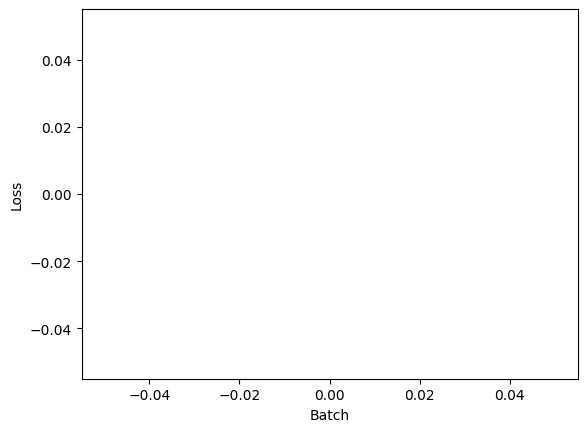

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("Batch")
plt.ylabel("Loss")

# Generate the text by using the trained LSTM

We will generate the text by using the trained LSTM. 

1. We will feed the first 30 characters into the LSTM.
2. Use the output to predict the next character. 
3. Add the predicted character to the input and remove the first character. 
4. Repeat this process to generate the text. 

A word is selected randomly based on the probability of the next character calculated by the softmax function as follows:
$$
P(w | w_{t-1}, w_{t-2}, \ldots, w_1) = \frac{\exp(\text{LSTM}(w)/T)}{\sum_{w'} \exp(\text{LSTM}(w')/T)}, 
$$
where $T>0$ represents the temperature parameter that controls the randomness of the output. A large temperature value results in a more random output, while a small temperature value results in a more deterministic output. 


In [22]:
def generate_text(
    lstm, start_text, length, window_length, char_to_int, int_to_char, temp
):
    """Generate text using the LSTM model

    Args:
    lstm: The LSTM model
    start_text: The starting text
    length: The length of the generated text
    window_length: The length of the input sequence
    char_to_int: The character to integer mapping
    int_to_char: The integer to character mapping

    Returns:
    generated_text: The generated text
    """
    start_text_as_int = [char_to_int[ch] for ch in start_text]
    generated_text = start_text_as_int

    for i in range(length):
        input_text = generated_text[-np.minimum(window_length, len(generated_text)) :]
        input_text = torch.tensor(input_text).view(1, -1)
        output = run_ltsm(input_text, lstm, 128)
        output = torch.softmax(output / temp, dim=1).multinomial(num_samples=1)
        generated_text.append(output.item())

    generated_text = [int_to_char[i] for i in generated_text]
    return "".join(generated_text)


generate_text(lstm, "My nam", 100, 30, char_to_int, int_to_char, temp=0.3)

'My nam the sall and and a don the he the ald the the the the the the serent and to the was the beat to the'

The generated text would not be readable. Still, you might see some unique words used in the book. Such as "Seldon", "Second Foundation".

Interested students are encouraged to expand the training data by changing the following line in the code at the third cell. 

```python 
#text_data = full_text_data[:10000] # old
text_data = full_text_data[:1000000] # new 
#text_data = full_text_data[:10000000] # (if you have time) 
```


If the learning is successful, the trained LTCM should be able to predict the next character better than a random prediction. 


In [23]:
with open(f"{root}/data/the-foundation-test.txt", "r", encoding="utf8") as fp:
    eval_text = fp.read()

eval_text = eval_text.replace("\n", " ")
eval_text = eval_text.replace("\r", " ")
eval_text

'Two Men and the Elders  The Elders of this particular region of Rossem were not exactly what one might have expected. They were not a mere extrapolation of the peasantry; older, more authoritative, less friendly.  Not at all.  The dignity that had marked them at first meeting had grown in impression till it had reached the mark of being their predominant characteristic.  They sat about their oval table like so many grave and slow-moving thinkers. Most were a trifle past their physical prime, though the few who possessed beards wore them short and neatly arranged. Still, enough appeared younger than forty to make it quite obvious that "Elders" was a term of respect rather than entirely a literal description of age.  The two from outer space were at the head of the table and in the solemn silence that accompanied a rather frugal meal that seemed ceremonious rather than nourishing, absorbed the new, contrasting atmosphere.  After the meal and after one or two respectful remarks - too sho

In [24]:
eval_text_as_int = [char_to_int[ch] for ch in eval_text]
inputs, targets = seq2input_target(eval_text_as_int, window_length=30)

output = run_ltsm(torch.tensor(inputs), lstm, 128)
predictions = torch.argmax(output, dim=1).view(-1).to("cpu").numpy()

# To char
predictions = np.array([int_to_char[i] for i in predictions])
targets = np.array([int_to_char[i] for i in targets])

acc = np.mean(predictions == np.array(targets))
rand_acc = 1.0 / len(char_set)

print(f"Accuracy: {acc:.4f}")
print(f"Random Accuracy: {rand_acc:.4f}")

Accuracy: 0.3651
Random Accuracy: 0.0120


# Submit the results

Please **git commit & push** the following two files created in the following cell. 

1. "~/assignments/lstm_test_predictions.txt" 

2. "~/assignments/lstm_loss_values.csv"


In [25]:
with open("./lstm_test_predictions.txt", "w", encoding="utf8") as f:
    for char in predictions:
        f.write(char)

pd.DataFrame(loss_values).to_csv("./lstm_loss_values.csv", index=False)